### Previsão de Faturamento para Serviços de Coleta de Resíduos
#### Banco de dados geral (todos os serviços)
Modelo utilizando SARIMAX e Modelos de Machine Learning
Dados das médias semanais de faturamento

#### IMPORTANDO BIBLIOTECAS

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro

import math
from math import sqrt

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### Definição de funções úteis

In [2]:
def mostra_resultados():
    mean_error = []

    print("1. Valores Previstos Por Algoritmo de Previsão:\n")
#     df_no_indices = pd.DataFrame()
    df_no_indices = df_preds.tail(df_preds.shape[0]).round(2).to_string(index=False)

    print(df_no_indices)
    print('\n')
    print("2. Gráfico de Métricas Por Algoritmo de Previsão:\n")
    plt.figure(figsize=(15,8))
    plt.plot(range(len(df_preds['SARIMA'])),df_preds['SARIMA'], 'g--', label='SARIMA')
    plt.plot(range(len(df_preds['LR'])),df_preds['LR'], ':', label='LR')
    plt.plot(range(len(df_preds['DT'])),df_preds['DT'], ':', label='DT')
    plt.plot(range(len(df_preds['RF'])),df_preds['RF'], 'k-.', label='RF')
#     plt.plot(range(len(df_preds['GB'])),df_preds['GB'], ':', label='GB')
    plt.plot(range(len(df_preds['LGBM'])),df_preds['LGBM'], ':', label='LGBM')
    plt.plot(range(len(df_preds['MLP'])),df_preds['MLP'], ':', label='MLP')
    plt.plot(range(len(df_preds['Real'])),df_preds['Real'], 'b-', label='Real')
    plt.legend()
    plt.title('Gráfico Real x Previsto')
    plt.show()
    
    print("\n3. Valores Das Métricas de Cada Algoritmo de Previsão:\n")
    print(df_metricas)

    print('\n')
    
    # Gráfico para Análise da Tendência da Previsão (grid)  
    print("4. Gráfico da Tendência das Previsões:\n")
    fig, ax = plt.subplots(2, 3, figsize=(16,6))

    for i,col in enumerate(df_preds.columns[1:]):
        # Calcula a tendência da previsão para cada modelo (por regressão linear)
        series = df_preds[col].values
        X = [i for i in range(0, len(series))]
        X = np.reshape(X, (len(X), 1))
        yy = series
        model = LinearRegression()
        model.fit(X, yy)
        # calculate trend
        trend = model.predict(X)

        if i <= 2:
#             sns.regplot(x=X, y=yy, ax=ax[0,i])
            ax[0,i].plot(yy)
            ax[0,i].plot(trend, color='orange')
            ax[0,i].set_title(col)
        else:
#             sns.regplot(x=X, y=yy, ax=ax[1,i-3])
            ax[1,i-3].plot(yy)
            ax[1,i-3].plot(trend, color='orange')
            ax[1,i-3].set_title(col)

#     fig.suptitle('Análise da Tendência')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()
    plt.clf()
    plt.close()
    
    print('\n')
    
    # Gráfico para Análise da Predição (grid)
    print("5. Gráfico de Dispersão Para Análise da Qualidade das Previsões:\n")
    fig, ax = plt.subplots(2, 3, figsize=(16,6))


    for i,col in enumerate(df_preds.columns[1:]):   
        #random_df.plot(kind='scatter', x=col, y='MEDV', ax=ax[i])
        series = df_preds['Real'].values
        X = [i for i in range(0, len(series))]
        X = np.reshape(X, (len(X), 1))
        yy = df_preds[col].values
        model = LinearRegression()
        model.fit(X, yy)
        # calculate trend
        trend = model.predict(X)
        if i <= 2:
#             sns.regplot(x=X, y=yy, ax=ax[0,i])
            ax[0,i].plot(trend)
            ax[0,i].scatter(x=X, y=yy)
            ax[0,i].set_title(col)
        else:
#             sns.regplot(x=X, y=yy, ax=ax[1,i-3])
            ax[1,i-3].plot(trend)
            ax[1,i-3].scatter(x=X, y=yy)
            ax[1,i-3].set_title(col)
        
#         if i <= 2:
#             sns.regplot(x=df_preds["Real"], y=df_preds[col], ax=ax[0,i])
#         else:
#             sns.regplot(x=df_preds["Real"], y=df_preds[col], ax=ax[1,i-3])      
    # ax[1,2].axis('off')                  # HIDES AXES ON LAST ROW AND COL

#     fig.suptitle('Análise da Previção')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()
    plt.clf()
    plt.close()

   
    # Gráfico do Erro (RMSE) passo a passo para o melhor modelo (r2)
    
    # Identifica o melhor modelo
    melhor_modelo = df_metricas['R2'].max()
    indice = np.where(df_metricas['R2'] == melhor_modelo)[0] # indice da linha do modelo
    modelo = df_metricas['Modelo'].loc[indice[0]] # nome do melhor modelo
    
    print('\n')
    print(f'6. Gráfico Do Erro Em Cada Passo Para o Melhor Modelo ({modelo}):\n')
    
    erro = ((np.array(df_preds['Real']) - np.array(df_preds[modelo]))**2)**(1/2)
    
    passos = df_preds.shape[0]
    
    # Plotando o gráfico de erro
    indice = np.arange(0,passos)
    plt.figure(figsize=(15,5))
    plt.plot(erro.round(2), '.--', color='g', markersize=6)
    plt.title('RMSE Para Cada Passo')
    plt.xlabel('Passos')
    plt.ylabel('Erro')
    for x,y in zip(indice, erro):
        label = "{:.2f}".format(y)
        plt.annotate(label, (x, y), xytext=(x-0.1, y+.075))
    plt.xticks(np.arange(passos), [x for x in range(1,passos+1)])
    plt.yticks([x for x in np.linspace(min(erro)-0.2, max(erro)+0.2, 10)])
    plt.grid(axis='y')
    plt.show()
    print(f'RMSE médio = {round(sum(erro)/len(erro),2)}')

In [3]:
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def checar_estacionariedade(y, lags_plots=48, figsize=(22,8)):
    "Use Series como parâmetro"
    
    # Criando plots do DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize) #, color='teal')
    ax1.set_title('Série de Médias Semanais')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2) #, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols') #, color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4) #, color='teal')
    ax4.set_title('Distribuição dos Valores de Serviços')

    plt.tight_layout()
    
    print('Resultados do teste de Dickey-Fuller:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Teste Statistico','Valor-P','Lags Usados','Números de Observações'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Valores Críticos (%s)"%key] = value.round(4)
        
    print(adftest)

#### CARREGANDO DADOS

In [4]:
df=pd.read_csv('residuos.csv')
# print(f'QUantidade de Serviços:{len(df["Produto"].unique())}')
df['Data'] = pd.to_datetime(df['Data'], format='%Y%m%d')
# Totaliza os valores por dia
df = df.groupby('Data')['Valor'].sum().reset_index()
df.sort_values('Data')

df.head(5)

,Data,Valor
0,2017-01-02,45671.11
1,2017-01-03,707912.02
2,2017-01-04,403451.35
3,2017-01-05,1198760.64
4,2017-01-06,192867.29


#### Análise descritiva e visual dos dados da série original

In [5]:
df.describe().round(2)

,Valor
count,1111.00
mean,421858.81
std,372504.41
min,0.52
25%,120215.07
50%,333935.95
75%,635080.14
max,3056888.88


#### Boxplot da Série de Valores Diários
O Boxplot é um diagrama de caixa construído utilizando as referências de valores mínimos e máximos, primeiro e terceiro quartil, mediana e outliers da base de dados.

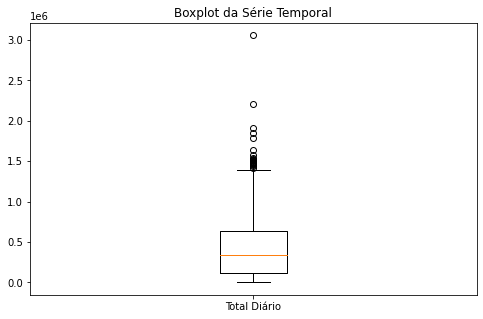

In [6]:
stick_label = ['Total Diário']
fig, ax = plt.subplots(figsize=(8,5))
plt.title('Boxplot da Série Temporal')
ax.boxplot(df['Valor'])
ax.set_xticklabels(stick_label)
plt.show()

#### Histograma da Série de Valores Diários

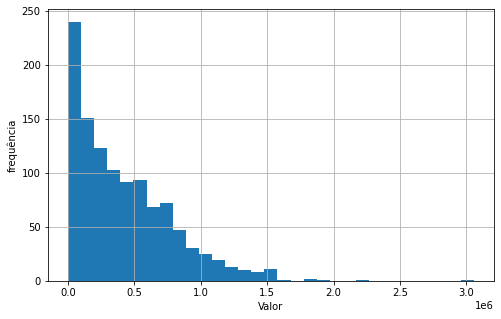

In [7]:
plt.figure(figsize=(8,5))
df['Valor'].hist(bins='auto')
plt.xlabel('Valor')
plt.ylabel('frequência')
plt.show()

#### Transformação da série de valores diários para média semanal

In [8]:
# Calcula a média diária e totaliza por semana
# y = df['Valor'].resample('MS').mean() #calcula a média por mês
# y = df['Valor'].resample('W-MON').mean()#calcula a média por semana
y = df.resample('W', on='Data')['Valor'].mean()#calcula a média por semana*
df = y.to_frame().reset_index()

In [9]:
# Cria campos para dia da semana, mês e ano
df['d_semana'] = df['Data'].dt.strftime("%u")
df['d_mes'] = df['Data'].dt.strftime("%d")
df['d_ano'] = df['Data'].dt.strftime("%j")

df['d_semana'] = df['d_semana'].astype(float)
df['d_mes'] = df['d_mes'].astype(float)
df['d_ano'] = df['d_ano'].astype(float)

df.tail(7)

,Data,Valor,d_semana,d_mes,d_ano
220,2021-03-28,130177.128000,7.0,28.0,87.0
221,2021-04-04,355901.110000,7.0,4.0,94.0
222,2021-04-11,780507.080000,7.0,11.0,101.0
223,2021-04-18,222107.594000,7.0,18.0,108.0
224,2021-04-25,190551.252857,7.0,25.0,115.0
225,2021-05-02,186117.305000,7.0,2.0,122.0
226,2021-05-09,616894.220000,7.0,9.0,129.0


#### Análise descritiva e visual dos dados da série de MÉDIAS SEMANAIS

In [10]:
df['Valor'].describe().round(2)

count        227.00
mean      420951.49
std       251421.57
min        44510.91
25%       210953.70
50%       373937.10
75%       629802.69
max      1108648.15
Name: Valor, dtype: float64

#### Boxplot e Histograma da Série de Médias Semanais

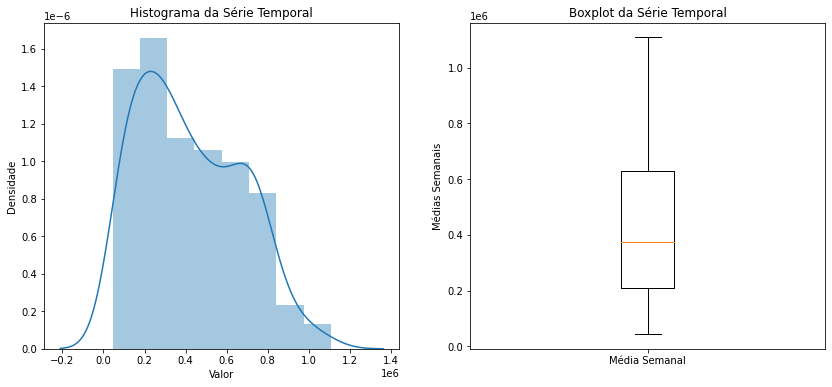

In [11]:
stick_label = ['Média Semanal']

plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
# ax1.hist(df['Valor'],density=False, histtype='bar') 
sns.distplot(df['Valor'])
plt.xlabel('Valor')
plt.ylabel('Densidade')
plt.title('Histograma da Série Temporal')

ax2= plt.subplot(1,2,2)
plt.ylabel('Médias Semanais')
plt.title('Boxplot da Série Temporal')
plt.boxplot(df['Valor'])
ax2.set_xticklabels(stick_label)
plt.show()


#### Teste de Normalidade Shapiro-Wilk

In [12]:
# normality test
stat, p = shapiro(df["Valor"])
print('Estatística=%.4f, p=%.4f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('A amostra parece Gaussiana (Falha em rejeitar H0)')
else:
	print('A amostra não parece Gaussiana (Rejeita-se H0)')

Estatística=0.9542, p=0.0000
A amostra não parece Gaussiana (Rejeita-se H0)


#### Série de Receitas da Médias Semanais

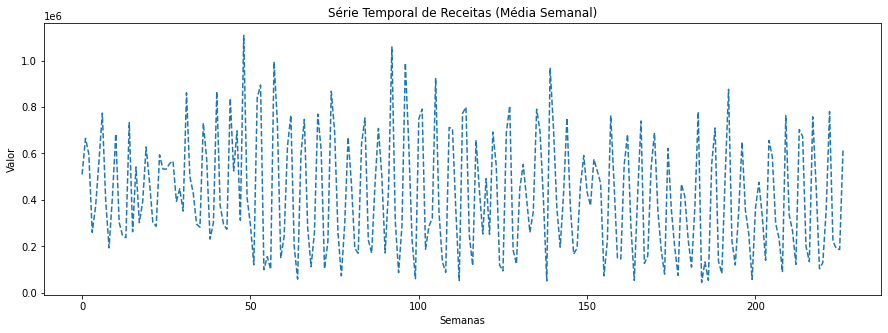

In [13]:
plt.figure(figsize=(15,5))
plt.plot(range(len(df)),df['Valor'].round(2), '--')
plt.title('Série Temporal de Receitas (Média Semanal)')
plt.xlabel('Semanas')
plt.ylabel('Valor')
plt.show()

#### Análise da Média da Série
Pelo gráfico, observa-se que a média se mantém constante ao longo do tempo.

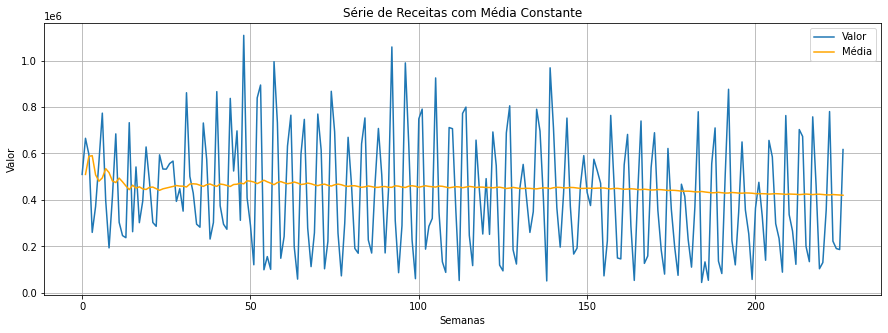

In [14]:
valor = df['Valor'].to_numpy()

#Criando uma média que se expande da primeira quantidade e acumulado até cada dia anterior
mean = [np.mean(valor[:x]) for x in range(len(valor))]

plt.figure(figsize=(15,5))
plt.plot(valor, label='Valor')
plt.plot(mean, label='Média', color='orange')
plt.title('Série de Receitas com Média Constante')
plt.xlabel('Semanas')
plt.ylabel('Valor')
# plt.xlim(1000,1400)
plt.grid()
plt.legend()
plt.show()

#### Teste de Dickey Fuller
Testes estatísticos para confirmar se a séries é estacionária. Vamos usar dois testes: o teste de [Dickey Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) e o teste [KPSS](https://en.wikipedia.org/wiki/KPSS_test).

Primeiramente vamos usar o teste de Dickey Fuller, usarei o [valor P](https://pt.wikipedia.org/wiki/Valor-p) base de 5%, ou seja, caso o valor P esteja abaixo desses 5% significa que a série é estatisticamente estacionária. 

Além disso, existe o **Teste estatístico** do modelo, onde estes valores podem ser comparados com os **valores críticos** de 1%, 5% e 10%, caso o teste estatístico esteja abaixo de algum valor critico escolhido a série será estacionária:

In [15]:
#Teste de Dickey Fuller
adfinput = adfuller(df['Valor']) # limita o teste da série em 365 exemplos
adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Valores Críticos (%s)"%key] = value.round(4) 
adftest

Teste Estatistico Dickey Fuller     -1.9971
Valor-P                              0.2878
Lags Usados                         12.0000
Número de observações usadas       214.0000
Valores Críticos (1%)               -3.4613
Valores Críticos (5%)               -2.8751
Valores Críticos (10%)              -2.5740
dtype: float64

Neste caso o teste de Dickey Fuller indicou que a série não é estacionária (Valor P de 28,78% é maior que o valor crítico de 5%.

#### Teste KPSS
O teste KPSS, ao contrário do teste de Dickey Fuller, já pressupõe que a série é estacionária e só não será se o valor P for inferior a 5% ou o teste estatístico for menor que algum valor crítico escolhido:

In [16]:
kpss_input = kpss(df['Valor']) # limita o teste da série em 365 exemplos
kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Valores Críticos (%s)"%key] = value 
kpss_test

Teste Statistico KPSS       0.8937
Valor-P                     0.0100
Lags Usados                15.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64

Neste caso o teste de KPSS indicou que a série é NÃO é estacionária (Valor P de 1% é menor que o valor crítico de 5%.

#### A Decomposição da Série
Toda série temporal pode ser decomposta em 3 partes: tendência, sazonalidade e resíduo, que é o que resta após retirar da série as duas primeiras partes, abaixo a separação dessas partes:

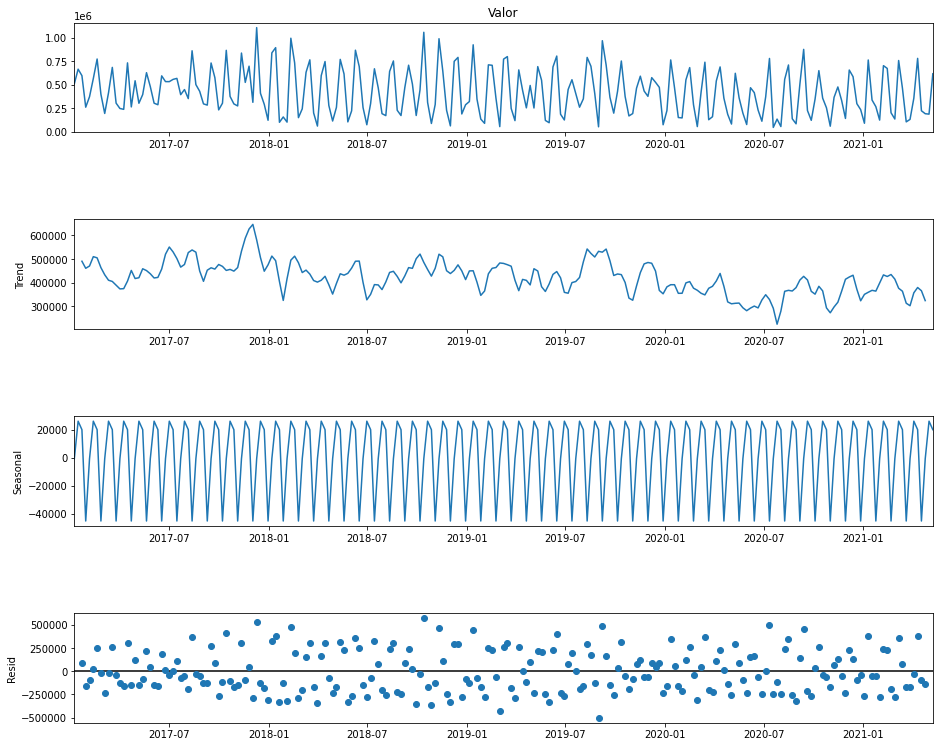

In [17]:
# Gráfico de decomposição da série de médias semanais
resultado = seasonal_decompose(y, model='additive', freq=4) # frequencia de 4 semanas=mensal
fig = resultado.plot();
fig.set_size_inches(15,12)

#### Analisando melhor a tendência

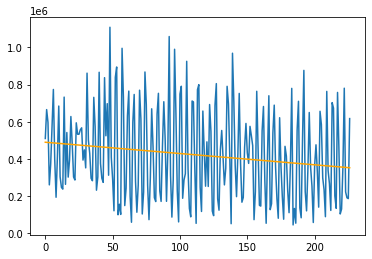

R2 da tendência: 0.025167916497429665


In [18]:
def mostra_tendencia(series):
    # fit linear model
    X = [i for i in range(0, len(series))]
    X = np.reshape(X, (len(X), 1))
    yy = series
    model = LinearRegression()
    model.fit(X, yy)
    # calculate trend
    trend = model.predict(X)
    # plot trend
    plt.plot(yy)
    plt.plot(trend, color='orange')
    plt.show()
    print("R2 da tendência:", model.score(X, yy))# R2 da tendência
mostra_tendencia(df['Valor'].values)

**Análise:** Se verifica uma leve tendência negativa para a série no período analisado. A sazonalidade se mostra em ciclos mensais (4 semanas) constantes e observa que há muitos resíduos que se apresentam em ciclos, também, mensais, sugerindo picos "aleátórios" de serviços.

# Autocorrelação

Para ter previsibilidade uma série com uma única variável deve ser autocorrelacionada, ou seja, o período atual deve ter explicação com base em um período anterior (**lag**).

Como esta série de quantidade de serviços têm períodos semanais, 1 ano tem 52 semanas, irei usar a função de autocorrelação para um período de 12 lags para verificar correlações do período atual com estes lags.

Resultados do teste de Dickey-Fuller:
Teste Statistico           -1.9971
Valor-P                     0.2878
Lags Usados                12.0000
Números de Observações    214.0000
Valores Críticos (1%)      -3.4613
Valores Críticos (5%)      -2.8751
Valores Críticos (10%)     -2.5740
dtype: float64


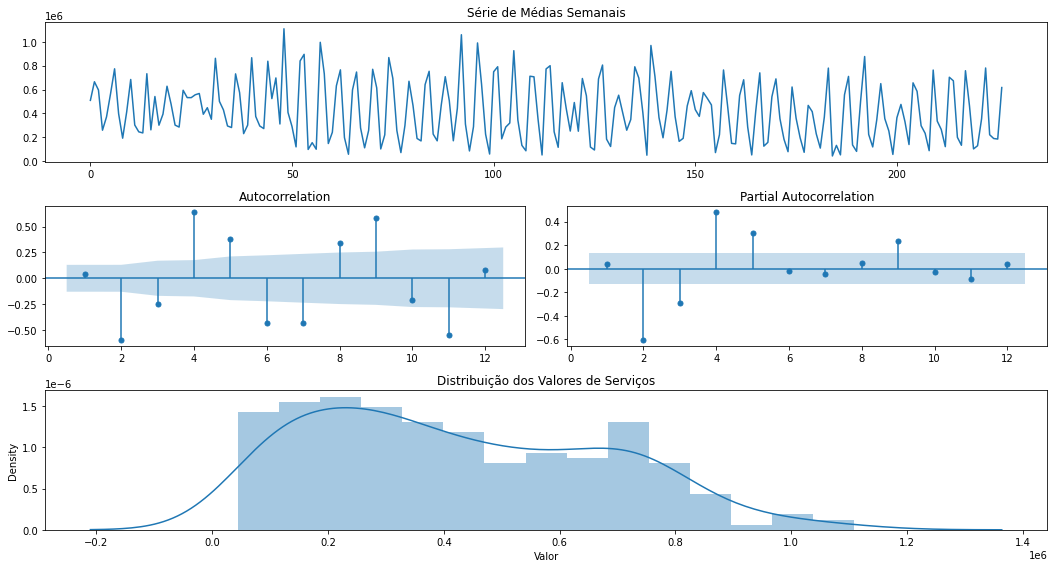

In [19]:
checar_estacionariedade(df['Valor'], lags_plots=12)

**Conclusão:** Ao analisar o gráfico de auto correlação gerado acima, verifica-se que os primeiros lags poderiam ser usados para criar previsões para eventos futuros, pois têm uma correlação positiva e estão fora do intervalo de confiança (área azul), ainda que indiquem correlação baixa (Não próximo a 1).

Uma outra função extremamente importante é a função de **auto correlação parcial**, onde o efeito do lag anterior sobre o período atual é removido e só resta o efeito do lag analisado sobre o período atual, exemplo: a auto correlação parcial do quarto lag irá remover o efeito do primeiro, segundo e terceiro lag.
    Observa-se que 2 lags têm efeito sobre o período atual. Usaremos somente os dois primeiros lags como fator de previsão para séries auto regressivas.

Resultados do teste de Dickey-Fuller:
Teste Statistico           -6.4161
Valor-P                     0.0000
Lags Usados                15.0000
Números de Observações    210.0000
Valores Críticos (1%)      -3.4619
Valores Críticos (5%)      -2.8754
Valores Críticos (10%)     -2.5742
dtype: float64


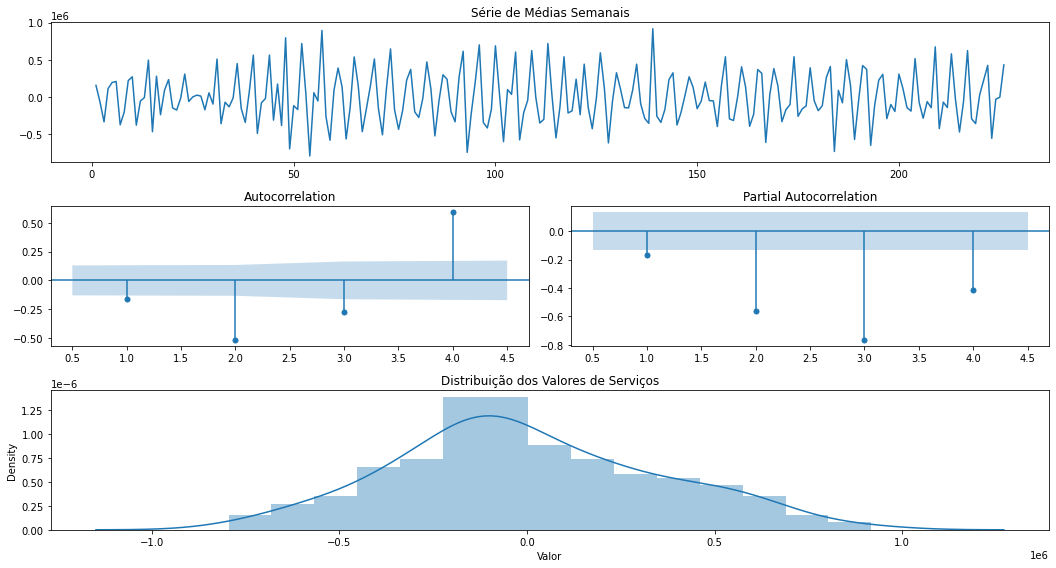

In [20]:
checar_estacionariedade(df['Valor'].diff().dropna(), lags_plots=4)

#### Dataset para o Modelo

In [21]:
# Seleciona colunas para permanecer no dataset do modelo
df_model = df.filter(['Valor','d_semana','d_mes','d_ano', 'Feriado'])
# # Excluir Outliers, ou seja, valores superiores a R$ 1.500.000,00
# df_model['Valor'] = df_model[df_model['Valor'] <= 1500000.00]

In [22]:
# df_model.head(2)

In [23]:
# plt.figure(figsize=(8,5))
# plt.title('Boxplot da Série Temporal')
# plt.boxplot(df_model['Valor'])
# plt.show()

In [24]:
# plt.figure(figsize=(8,5))
# df_model['Valor'].hist(bins='auto')
# plt.xlabel('Valor')
# plt.ylabel('frequência')
# plt.show()

#### MODELANDO COMO UM PROBLEMA DE SÉRIE TEMPORAL

In [85]:
time_steps = 52 # 52 semanas no ano
test_size = 4

train_size = int(len(df_model)-(test_size))
train, test = df_model.iloc[0:train_size], df_model.iloc[(train_size-time_steps):len(df_model)]
print(len(train), len(test))

223 56


In [86]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        v = np.append(v,X.iloc[i + time_steps,1])#d_semana
        v = np.append(v,X.iloc[i + time_steps,2])#d_mes
        v = np.append(v,X.iloc[i + time_steps,3])#d_ano
#         v = np.append(v,X.iloc[i + time_steps,4])#feriados
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train['Valor'], time_steps)
X_test, y_test = create_dataset(test, test['Valor'], time_steps)

print("Treino:", len(X_train), "Teste:", len(X_test))

# X_train[0]

Treino: 171 Teste: 4


#### VALIDANDO O MODELO

In [87]:
# Função para validar o modelo SARIMAX
def validacao_arima(model):
    dt_ini = df['Data'].iloc[-test_size]
    pred = model.get_prediction(start=pd.to_datetime(dt_ini), dynamic=False)
    return pred.predicted_mean.values

In [88]:
# Função para validar os modelos de Machine Learning
def validacao(model):
    preds = []

    base_teste = np.copy(X_test)

    for i in range(len(base_teste)):
        y_pred = model.predict(np.array([base_teste[i]]))[0]
        preds.append(y_pred)

        for k in range(len(preds)):

            if i<len(base_teste):
                if k < time_steps:
                    if(i<len(base_teste)-1):
                        base_teste[i+1][(time_steps-1)-k] = preds[(len(preds)-1)-k]
                
       
    return preds

#### Gera as métricas das predições

In [89]:
# Gera as métricas das predições
def metricas(real, predito):
    rmse = round(sqrt(mean_squared_error(real,predito)),2)
    mae  = round(mean_absolute_error(real,predito),2)
    mape = round(100*mean_absolute_percentage_error(real,predito),2)
    r2   = round(r2_score(real,predito),4)
    return rmse, mae, mape, r2

#### CRIANDO E TREINANDO UM MODELO

In [90]:
# Prepare models
models = []
models.append(('SARIMA', sm.tsa.statespace.SARIMAX(y,order=(1, 1, 1),seasonal_order=(1,1,0,52),
                                                        enforce_invertibility=False)))
models.append(('LR', LinearRegression()))
models.append(('DT', DecisionTreeRegressor(criterion='mse')))
models.append(('RF', RandomForestRegressor()))
# models.append(('GB', GradientBoostingRegressor()))
models.append(('LGBM', LGBMRegressor()))
models.append(('MLP', MLPRegressor()))
# Evaluate each model in turn
names = []
preds = {}
df_preds    = pd.DataFrame()
df_metricas = pd.DataFrame()
dados_real  = df_model.iloc[(train_size):len(df_model),0].to_numpy()
df_preds['Real'] = dados_real

idx = 0
for name, mod in models:
    
    preditos = []
    maes     = []
    rmses    = []
    mapes    = []
    r2s      = []
    
    names.append(name) # nome no modelo
    
    # Exeecuta um modelo 10 vezes para obter a média das métricas
    for i in range(1,101):
        if name == 'SARIMA':
            model = mod.fit()
            predito = validacao_arima(model)
        else:
            model = mod.fit(X_train, y_train)
            predito = validacao(model)
        preditos.append(predito)
        
    # Calcula a média das predições de cada modelo
    media_preditos = np.mean(preditos, axis=0)
    preds[name] = media_preditos
    # Cria colunas no dataset para as predições de cada modelo
    df_preds[name] = preds[name]
    rmse, mae, mape, r2 = metricas(dados_real, media_preditos)

    df_metricas.loc[idx,'Modelo'] = name
    df_metricas.loc[idx,'MAE']  = mae
    df_metricas.loc[idx,'RMSE'] = rmse
    df_metricas.loc[idx,'MAPE(%)'] = mape
    df_metricas.loc[idx,'R2']   = r2
    idx += 1

1. Valores Previstos Por Algoritmo de Previsão:

     Real    SARIMA        LR        DT        RF      LGBM       MLP
222107.59 310772.14 262012.47 362279.17 319696.88 229163.62 310445.24
190551.25 243486.55  92610.40 137471.56 202762.43 232510.95 138438.94
186117.31  88969.44 112741.67 380820.59 203278.80 174077.72 118515.97
616894.22 619119.95 757857.13 593987.30 581044.35 646597.02 683164.37


2. Gráfico de Métricas Por Algoritmo de Previsão:



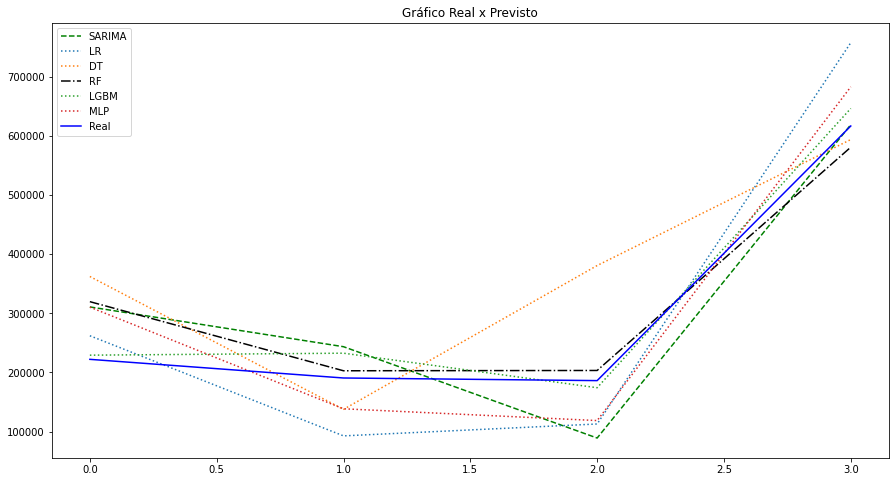


3. Valores Das Métricas de Cada Algoritmo de Previsão:

   Modelo        MAE       RMSE  MAPE(%)      R2
0  SARIMA   60243.36   70898.18    30.06  0.8470
1      LR   88046.07   95445.45    32.91  0.7226
2      DT  102715.37  123389.24    49.82  0.5364
3      RF   40702.96   53038.93    16.34  0.9143
4    LGBM   22689.53   26634.62     9.12  0.9784
5     MLP   68580.36   69787.01    28.55  0.8517


4. Gráfico da Tendência das Previsões:



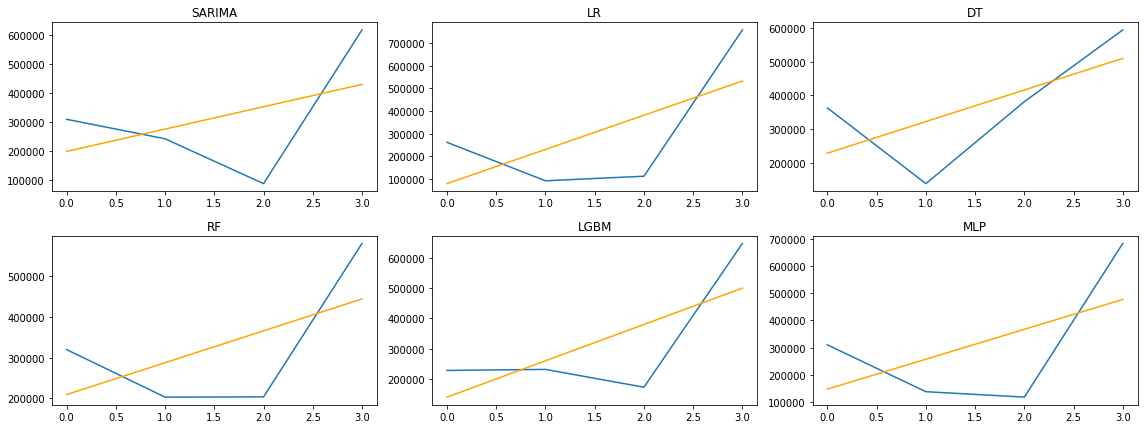



5. Gráfico de Dispersão Para Análise da Qualidade das Previsões:



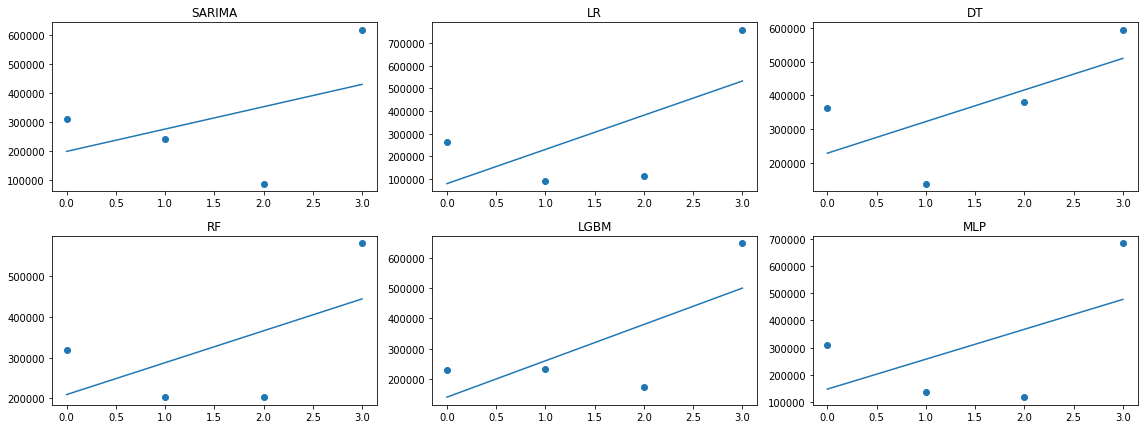



6. Gráfico Do Erro Em Cada Passo Para o Melhor Modelo (LGBM):



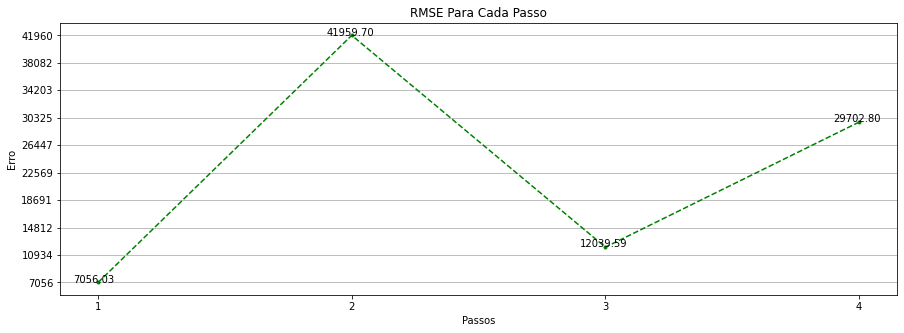

RMSE médio = 22689.53


In [91]:
mostra_resultados()